In [1]:
from os import path
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate

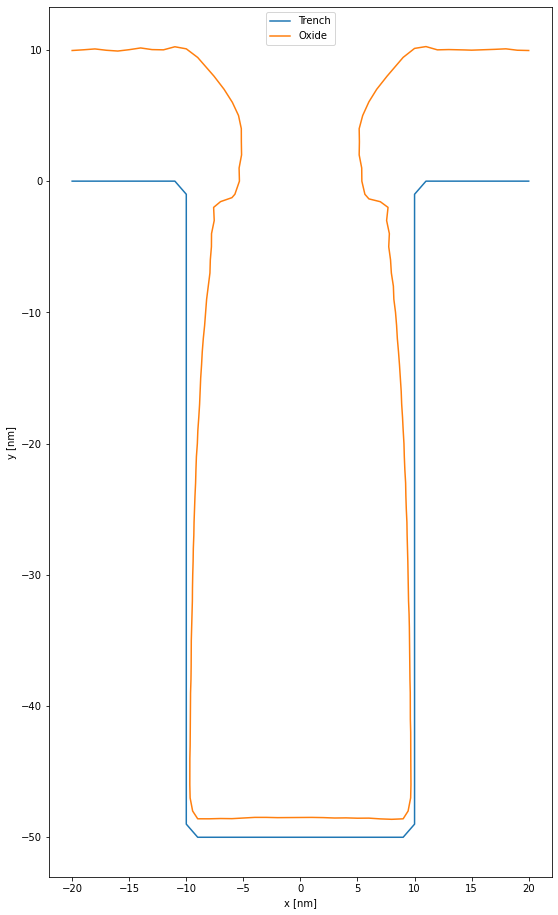

In [2]:
def extract_line(filename):
    # Read the VTP file
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(filename)
    reader.Update()

    # Extract the polygon data
    polydata = reader.GetOutput()

    # Apply a filter to connect contiguous line segments
    # (This step is necessary since otherwise we would have many small line elements)
    strip = vtk.vtkStripper()
    strip.SetInputData(polydata)
    strip.SetJoinContiguousSegments(True)
    strip.Update()

    # Retrieve the filter output
    filtered = strip.GetOutput()

    # Extract Points
    point_coordinates = vtk_to_numpy(filtered.GetPoints().GetData())

    # Extract Line data
    lines = filtered.GetLines()
    lines_array = vtk_to_numpy(lines.GetData())

    # Connectivity array and offset array are only important if the line is not contiguous
    #connectivity_array = vtk_to_numpy(lines.GetConnectivityArray())
    #offset_array = vtk_to_numpy(lines.GetOffsetsArray())

    # Extract the surface line (as separate x, y and z array)
    return zip(*point_coordinates[lines_array[1:]])

# Extract interface lines
tx, ty, _ = extract_line(path.join("output", "results_8bit", "Interface_0_0.vtp"))
x, y, _ = extract_line(path.join("output", "results_8bit", "Interface_1_10.vtp"))

# Plot the line
fig, ax = plt.subplots(figsize=(9,16))
ax.plot(tx, ty, label="Trench")
ax.plot(x, y, label="Oxide")

# Label plot
ax.set_xlabel("x [nm]")
ax.set_ylabel("y [nm]")
ax.legend(loc="upper center")
plt.show()